<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/ImgRec/VGG_cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG

元論文 >> Very Deep Convolutional Networks for Large-Scale Image Recognition https://arxiv.org/abs/1409.1556 (2014)

conv(3x3)のカーネルを16 or 19重ねたcnn構造。

<img src="images/conv3_5.png" width=400> 

conv(3x3)を2回重ねると、conv(5x5)と同じ畳み込み範囲（receptive field)になり、かつ非線形性(nonlinearity)が拡大するので、特徴抽出がしやすくなる。

非線形の拡大とは、convolution操作は 

$y=f(x)$

になるが、conv層が2層重なると、

$y=f_2(f_1(x))$

になり、複雑な出力を表現できることを意味しているのだと思う。

16と19層使う２種類があるが、19は数の割りにそこまで精度の向上がないので、vgg16の方が使われる。SoTAの精度というより、安定して収束しやすいのでResNetや他のCNNがある今でもたまに使われることもある。

<img src="images/vgg_all.png" width=400>



In [1]:
!pip install -q --upgrade albumentations==0.5.1

     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 952kB 20.7MB/s 
     |████████████████████████████████| 36.7MB 84kB/s 


# torchvision

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

def get_model(out_dim, dropout=0.5, pretrained=True):
    model = models.vgg16(pretrained=True)
    del model.fc
    
    model.fc = nn.Sequential(
        nn.Linear(2048, out_dim),
    )

    return model

# scratch

## VGG16

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(-1)

class VGG16(nn.Module):
    def __init__(self, out_dim, in_height=32, in_width=32):
        super(VGG16, self).__init__()

        self.in_height = in_height
        self.in_width = in_width

        class VGGBlock(nn.Module):
            def __init__(self, in_dim, dim, stride=1, repeat=3):
                super(VGGBlock, self).__init__()

                self.stride = stride

                module = []

                for i in range(repeat):
                    _in_dim= in_dim if i == 0 else dim
                    module.append(nn.Conv2d(_in_dim, dim, kernel_size=3, padding=1, stride=1))
                    module.append(nn.BatchNorm2d(dim))
                    module.append(nn.ReLU())    

                self.module = nn.Sequential(*module)
                
            def forward(self, x):
                return self.module(x)
        
        self.module = nn.Sequential(
            VGGBlock(3, 64),
            nn.MaxPool2d([2, 2], padding=1, stride=2),
            VGGBlock(64, 128),
            nn.MaxPool2d([2, 2], padding=1, stride=2),
            VGGBlock(128, 256),
            nn.MaxPool2d([2, 2], padding=1, stride=3),
            VGGBlock(256, 512),
            nn.MaxPool2d([2, 2], padding=1, stride=3),
            VGGBlock(512, 512),
            nn.MaxPool2d([2, 2], padding=1, stride=3),
        )

        self.flatten = Flatten()

        self.top = nn.Sequential(
            nn.Linear((self.in_height // 32) * (self.in_width // 32) * 512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, out_dim),
        )

        
    def forward(self, x):
        x = self.module(x)
        x = self.flatten(x)
        x = self.top(x)
        return x

## VGG19

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Flatten(torch.nn.Module):
    def forward(self, x):
        mb = len(x)
        return x.view(mb, -1)

class VGG19(nn.Module):
    def __init__(self, out_dim, in_height=32, in_width=32):
        super(VGG19, self).__init__()

        self.in_height = in_height
        self.in_width = in_width

        class VGGBlock(nn.Module):
            def __init__(self, in_dim, dim, stride=1, repeat=3):
                super(VGGBlock, self).__init__()

                self.stride = stride

                module = []

                for i in range(repeat):
                    _in_dim= in_dim if i == 0 else dim
                    module.append(nn.Conv2d(_in_dim, dim, kernel_size=3, padding=1, stride=1))
                    module.append(nn.BatchNorm2d(dim))
                    module.append(nn.ReLU())    

                self.module = nn.Sequential(*module)
                
            def forward(self, x):
                return self.module(x)
        
        self.module = nn.Sequential(
            VGGBlock(3, 64),
            nn.MaxPool2d([2, 2], padding=1, stride=2),
            VGGBlock(64, 128),
            nn.MaxPool2d([2, 2], padding=1, stride=2),
            VGGBlock(128, 256),
            nn.MaxPool2d([2, 2], padding=1, stride=4),
            VGGBlock(256, 512),
            nn.MaxPool2d([2, 2], padding=1, stride=4),
            VGGBlock(512, 512),
            nn.MaxPool2d([2, 2], padding=1, stride=4),
        )

        self.flatten = Flatten()

        self.top = nn.Sequential(
            nn.Linear((self.in_height // 32) * (self.in_width // 32) * 512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, out_dim),
        )

        
    def forward(self, x):
        x = self.module(x)
        x = self.flatten(x)
        x = self.top(x)
        return x

# Import

In [5]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [6]:
IN_HEIGHT, IN_WIDTH = 32, 32

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

# prepare data

In [7]:
train_ds = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=None)
train_Xs = train_ds.data
train_ys = np.array(train_ds.targets)

class CifarDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

Extracting ./cifar-10-python.tar.gz to ./


In [8]:
transforms_train = A.Compose([
    A.RandomResizedCrop(IN_HEIGHT, IN_WIDTH, scale = (0.9,1.0),ratio = (0.9,1.1),p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1,val_shift_limit=0.1,p=0.2),
    A.RandomBrightnessContrast(brightness_limit = (-0.2,0.2), contrast_limit = (-0.1,0.1), p=0.2),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    A.Resize(IN_HEIGHT, IN_WIDTH),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [9]:
def train():
    # fold
    if FOLD == "KFold":
        kf = KFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds)
        
    elif FOLD == "GroupKFold":
        kf = GroupKFold(n_splits=FOLD_N)
        spl = kf.split(train_ds.data, train_ds.targets, train_ds.targets)
        
    elif FOLD == "StratifiedKFold":
        kf = StratifiedKFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds.data, train_ds.targets)

    else:
        print("invalid fold")
        return None
    
    train_models = []
    train_model_paths = []

    val_cv_loss = []
    val_cv_accuracy = []
    
    val_cv_labels = []
    val_cv_preds = []

    EPOCH = 30
    
    for fold_i, (train_idx, val_idx) in enumerate(spl):
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        print(f"{FOLD} fold:{fold_i + 1}/{FOLD_N}")
        print(f"train_N={len(train_idx)}, val_N={len(val_idx)}")
            
        #---
        # datasert
        #---
        X_train = train_Xs[train_idx]
        y_train = train_ys[train_idx]
        X_val = train_Xs[val_idx]
        y_val = train_ys[val_idx]

        dataset_train = CifarDataset(X_train, y_train, transforms=transforms_train)
        dataset_val = CifarDataset(X_val, y_val, transforms=transforms_val)

        dataloader_train = DataLoader(dataset_train, batch_size=256, num_workers=4, shuffle=True, pin_memory=True)
        dataloader_val = DataLoader(dataset_val, batch_size=256, num_workers=4, shuffle=False, pin_memory=True)
        
        train_n = len(X_train)
        val_n = len(X_val)
        target_n = 1
        
        #---
        # model
        #---
        # model = get_model(out_dim=10, pretrained=True, dropout=0.5)
        model = VGG16(out_dim=10)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss(reduction="sum")
        # criterion = nn.BCELoss(reduction="sum")
        # optimizer = optim.SGD(model.parameters(), lr=0.01)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        # lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[50], gamma=0.1, last_epoch=-1)
    
        #---
        # epoch
        #---
        for epoch in range(EPOCH):

            model.train()
            
            tr_loss = 0
            correct = 0
            total = 0
            
            #---
            # train
            #---
            train_time_start = time.time()
            
            for step, batch in enumerate(dataloader_train):
                optimizer.zero_grad()

                xs = batch[0].to(device) # image
                ys = batch[1].to(device) # target
            
                outputs = model(xs)
             
                loss = criterion(outputs, ys)
                        
                loss = loss / train_n
                loss.backward()

                loss = loss.item()
                tr_loss += loss
                
                _, predicted = torch.max(outputs.data, 1)
                total += ys.size(0)
                correct += (predicted == ys).sum().item()

                optimizer.step()

            train_losses.append(tr_loss)
            
            train_accuracy = correct / total
            train_accuracies.append(train_accuracy)

            train_time_end = time.time()

            #---
            # val
            #---
            model.eval()

            val_loss = 0
            val_correct = 0
            val_total = 0
            
            val_time_start = time.time()
            
            val_labels = []
            val_preds = []
            
            with torch.no_grad():
                for step, batch in enumerate(dataloader_val):
                    xs = batch[0].to(device) # image
                    ys = batch[1].to(device) # target
                    
                    outputs = model(xs)

                    loss = criterion(outputs, ys)
                        
                    val_loss += loss.item() / val_n
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += ys.size(0)
                    val_correct += (predicted == ys).sum().item()
                    
                    val_labels.extend(ys.detach().cpu().numpy().tolist())
                    val_preds.extend(predicted.detach().cpu().numpy().tolist())

            val_time_end = time.time()
            train_time_total = train_time_end - train_time_start
            val_time_total = val_time_end - val_time_start
            total_time = train_time_total + val_time_total
                
            val_losses.append(val_loss)
            
            val_accuracy = val_correct / val_total
            val_accuracies.append(val_accuracy)

            print(f"fold:{fold_i + 1} epoch:{epoch + 1}/{EPOCH} [tra]loss:{tr_loss:.4f} acc:{train_accuracy:.4f}  [val]loss:{val_loss:.4f} acc:{val_accuracy:.4f}  [time]total:{total_time:.2f}sec tra:{train_time_total:.2f}sec val:{val_time_total:.2f}sec")

#             lr_scheduler.step()


            if (epoch + 1) % 100 == 0:
                savename = f"model_epoch{epoch + 1}_{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
                torch.save(model.state_dict(), savename)
                print(f"model saved to >> {savename}")

        #---
        # store last val loss and accuracy
        #---
        val_cv_loss.append(val_loss)
        val_cv_accuracy.append(val_accuracy)
        
        val_cv_labels.extend(val_labels)
        val_cv_preds.extend(val_preds)
           
        #---
        # save model
        #---
        savename = f"model_epoch{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
        torch.save(model.state_dict(), savename)
        print(f"model saved to >> {savename}")
        print()
        
        train_models.append(model)
        train_model_paths.append(savename)
        

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        ax2.plot(train_accuracies, marker=".", markersize=6, color="green", label="train accuracy")
        ax2.plot(val_accuracies, marker=".", markersize=6, color="orange", label="val accuracy")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()
        
    
    #---
    # display fold score
    #---
    val_cv_loss = np.array(val_cv_loss)
    val_cv_accuracy = np.array(val_cv_accuracy)
    
    print("all folds score")
    print(f"total loss:{val_cv_loss.mean():.6f}, accuracy:{val_cv_accuracy.mean():.6f}")
    for i in range(FOLD_N):
        print(f"fold{i + 1}/{FOLD_N} loss:{val_cv_loss[i]:.6f}, accuracy:{val_cv_accuracy[i]:.6f}")
        
    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":val_cv_labels, "pred":val_cv_preds})
    print()
    print("cross table")
    display(pd.crosstab(res_df["label"], res_df["pred"]))
        
    return train_models, train_model_paths

StratifiedKFold fold:1/2
train_N=25000, val_N=25000
fold:1 epoch:1/30 [tra]loss:2.2692 acc:0.1289  [val]loss:2.2077 acc:0.1701  [time]total:30.15sec tra:23.75sec val:6.40sec
fold:1 epoch:2/30 [tra]loss:2.0607 acc:0.2072  [val]loss:2.0648 acc:0.1975  [time]total:32.60sec tra:25.86sec val:6.74sec
fold:1 epoch:3/30 [tra]loss:2.0105 acc:0.2236  [val]loss:2.0642 acc:0.2052  [time]total:31.18sec tra:24.76sec val:6.42sec
fold:1 epoch:4/30 [tra]loss:1.9800 acc:0.2392  [val]loss:1.9001 acc:0.2570  [time]total:31.20sec tra:24.64sec val:6.56sec
fold:1 epoch:5/30 [tra]loss:1.9248 acc:0.2570  [val]loss:1.9004 acc:0.2716  [time]total:31.52sec tra:24.95sec val:6.57sec
fold:1 epoch:6/30 [tra]loss:1.8883 acc:0.2711  [val]loss:1.8335 acc:0.2939  [time]total:31.31sec tra:24.77sec val:6.54sec
fold:1 epoch:7/30 [tra]loss:1.8541 acc:0.2896  [val]loss:1.7344 acc:0.3088  [time]total:31.32sec tra:24.77sec val:6.55sec
fold:1 epoch:8/30 [tra]loss:1.8353 acc:0.2952  [val]loss:1.7904 acc:0.3149  [time]total:31.54s

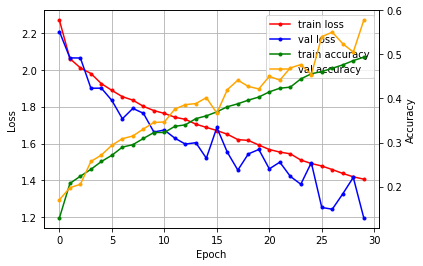

StratifiedKFold fold:2/2
train_N=25000, val_N=25000
fold:2 epoch:1/30 [tra]loss:2.1782 acc:0.1696  [val]loss:2.0825 acc:0.1973  [time]total:31.51sec tra:24.89sec val:6.62sec
fold:2 epoch:2/30 [tra]loss:2.0287 acc:0.2151  [val]loss:1.9793 acc:0.2329  [time]total:31.69sec tra:25.14sec val:6.54sec
fold:2 epoch:3/30 [tra]loss:1.9821 acc:0.2285  [val]loss:1.9662 acc:0.2588  [time]total:31.44sec tra:24.89sec val:6.55sec
fold:2 epoch:4/30 [tra]loss:1.9423 acc:0.2507  [val]loss:1.8742 acc:0.2637  [time]total:31.38sec tra:24.82sec val:6.56sec
fold:2 epoch:5/30 [tra]loss:1.8939 acc:0.2681  [val]loss:1.8833 acc:0.2850  [time]total:31.63sec tra:25.05sec val:6.58sec
fold:2 epoch:6/30 [tra]loss:1.8561 acc:0.2776  [val]loss:1.8352 acc:0.2747  [time]total:31.44sec tra:24.92sec val:6.52sec
fold:2 epoch:7/30 [tra]loss:1.8324 acc:0.2850  [val]loss:1.7933 acc:0.2938  [time]total:31.30sec tra:24.76sec val:6.54sec
fold:2 epoch:8/30 [tra]loss:1.8070 acc:0.2930  [val]loss:1.8022 acc:0.3050  [time]total:31.54s

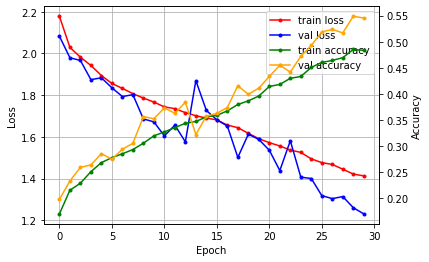

all folds score
total loss:1.213274, accuracy:0.561520
fold1/2 loss:1.196040, accuracy:0.577600
fold2/2 loss:1.230508, accuracy:0.545440

cross table


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,3466,250,321,31,18,27,41,128,513,205
1,245,3810,26,56,2,6,38,20,137,660
2,685,119,1965,381,399,238,675,352,146,40
3,185,212,391,1881,91,991,642,289,220,98
4,196,27,750,352,1643,211,1039,713,51,18
5,97,204,295,1239,125,2191,232,372,182,63
6,56,69,314,464,121,44,3860,29,37,6
7,149,119,221,328,223,442,134,3118,120,146
8,904,477,97,51,4,14,87,29,3220,117


In [10]:
train_models, train_model_paths = train()

# Test

In [12]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    test_ds = torchvision.datasets.CIFAR10(root="./", train=False, download=True, transform=None)
    test_Xs = test_ds.data
    test_ys = np.array(test_ds.targets)

    dataset_test = CifarDataset(test_Xs, test_ys, transforms=transforms_val)
    dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)

    preds = []
    correct = 0

    with torch.no_grad():
         for step, batch in enumerate(dataloader_test):
            Xs = batch[0].to(device) # image
            ys = batch[1]

            _preds = np.zeros([len(ys), 10])

            for model in train_models:
                model_preds = F.softmax(model(Xs), dim=1).detach().cpu().numpy()
                _preds += model_preds / model_num

            _preds = _preds.argmax(axis=1)

            preds.extend(_preds)

            correct += sum(ys.numpy() == _preds)

    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":test_ys, "pred":preds})
    print()
    print("cross table")
    cross = pd.crosstab(res_df["label"], res_df["pred"])

    accuracy = correct / len(test_ys)
    print(f"accuracy = {accuracy:.4f} ({correct} / {len(test_ys)})")

    display(cross)


test(train_models)

Files already downloaded and verified

cross table
accuracy = 0.5933 (5933 / 10000)


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,748,36,37,10,2,3,3,20,105,36
1,34,804,2,4,0,1,8,3,16,128
2,149,19,399,74,59,53,157,69,14,7
3,45,56,72,391,16,168,148,49,49,6
4,31,8,129,70,337,34,235,142,12,2
5,25,31,55,234,20,458,39,77,49,12
6,7,10,45,68,6,8,841,5,10,0
7,34,14,30,62,35,83,32,649,24,37
8,185,80,14,11,0,3,9,4,678,16
